## Import

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

# variabile data per il salvataggio file
file_date = dt.now().strftime('%d%m%y')

## Scraping

In [2]:
from bs4 import BeautifulSoup as BeautifulSoup
# abilita descrizione stato dello scraping
verbose = True

### Nero Giardini

In [3]:
n = 1 # contatore

url_cat = ['donna', 'uomo'] # categorie url nerogiardini
url_pages = ['', '/saldi']

# liste dati
prod_id = []
prod_category = []
prod_name = []
prod_price = []
prod_sales = []
prod_colors = []
prod_gender = []

# ciclo per pagine
for page in url_pages:
    # ciclo per categorie
    for cat in url_cat:
        for i in range(1, 100):  # scorrimento tra 100 pagine per il paramtro p=
            url = f'https://nerogiardini.it/it/{cat}{page}/calzature?p=' + str(i)
            req = requests.get(url)

            # break se lo status_code è diverso da 200 
            if req.status_code != 200:
                if verbose:
                    print(f'Page: {url} --> \033[41mStatus Code {req.status_code}\033[0m')
                break          
            soup = BeautifulSoup(req.text)

            all_prod = soup.select('li.item.product')
            
            # break in caso non ci sono più prodotti
            if len(all_prod) == 0: 
                break;

            # ciclo per ogni prodotto
            for prod in all_prod:
                prod_id.append(prod['class'][-1])
                prod_name.append(prod.findAll('h2')[0].get_text(strip=True))
                prod_category.append(prod_name[-1].lower().split(' ' + cat)[0].capitalize())

                price = float(prod.findAll('span', class_='price')[0].get_text(strip=True).replace('\xa0€','').replace(',', '.'))
                
                if 'saldi' in page:
                    prod_sales.append(price)
                    prod_price.append(None)
                else:    
                    prod_price.append(price)
                    prod_sales.append(None)
                
                prod_gender.append(cat.capitalize())
                colors_variant = prod.select('div.variant')        
                color_list = []
                if len(colors_variant):
                    for color in colors_variant:
                        color_list.append(color['alt'])
                else:
                    color_list = None
                prod_colors.append(color_list)
    
                if verbose:
                    print(n, prod_id[-1], prod_category[-1], prod_name[-1], prod_price[-1], prod_sales[-1], prod_colors[-1],  sep='\t')
                    n+=1
            if verbose:
                print(f'Page {i}: {url} --> \033[42mStatus OK\033[0m')

1	25P_E011041DE	Décolleté	Décolleté Donna in Vernice	149.5	None	None
2	25P_E011073DE	Décolleté	Décolleté Donna in Pelle	149.5	None	['Nero', 'Rosa']
3	25P_E011084DE	Décolleté	Décolleté Donna in Pelle	149.5	None	None
4	25P_E011085DE	Décolleté	Décolleté Donna in Vernice	149.5	None	None
5	25P_E012830DE	Sandali	Sandali Donna in Materiale Tecnico	179.5	None	['Marrone', 'Rosa', 'Argento']
6	25P_E115530D	Sandali	Sandali Donna in Suede	119.5	None	['Nero', 'Beige']
7	25P_E211041DE	Décolleté	Décolleté Donna in Vernice	149.5	None	['Nero', 'Rosso']
8	25P_E211070DE	Décolleté	Décolleté Donna in Pelle	145.0	None	None
9	25P_E211072DE	Décolleté	Décolleté Donna in Pelle	149.5	None	['Nero', 'Rosa']
10	25P_E218210D	Sabot	Sabot Donna in Pelle	129.5	None	None
11	25P_E218212D	Mocassini	Mocassini Donna in Pelle	135.0	None	None
12	25P_E218331DE	Décolleté	Décolleté Donna in Pelle	149.5	None	None
Page 1: https://nerogiardini.it/it/donna/calzature?p=1 --> Status OK
13	25P_E218332DE	Décolleté	Décolleté Donna in Pel

In [5]:
# creazione del dataframe
nero_dict = {'id': prod_id, 'category': prod_category, 'name': prod_name, 'price': prod_price, 'sales_price' : prod_sales, 'color':prod_colors, 'gender': prod_gender} 
nero_df = pd.DataFrame(nero_dict)

# sostituzione della categoria con typing errato 'Snekares'
nero_df.category = nero_df.category.replace('Snekares', 'Sneakers')
nero_df.category = nero_df.category.replace('Sneakers alta', 'Sneakers') 
nero_df.category = nero_df.category.replace('Mocassini mono fibbia', 'Mocassini') 

nero_df = nero_df.explode('color').reset_index(drop=True).drop_duplicates(subset=['id', 'color'])
nero_df.to_csv(f'csv/nerogiard_scrap_{file_date}.csv')
nero_df

,id,category,name,price,sales_price,color,gender
0,25P_E011041DE,Décolleté,Décolleté Donna in Vernice,149.5,NaN,None,Donna
1,25P_E011073DE,Décolleté,Décolleté Donna in Pelle,149.5,NaN,Nero,Donna
2,25P_E011073DE,Décolleté,Décolleté Donna in Pelle,149.5,NaN,Rosa,Donna
3,25P_E011084DE,Décolleté,Décolleté Donna in Pelle,149.5,NaN,None,Donna
4,25P_E011085DE,Décolleté,Décolleté Donna in Vernice,149.5,NaN,None,Donna
...,...,...,...,...,...,...,...
1166,24A_I102155U,Sneakers,Sneakers Uomo in Pelle,NaN,125.5,None,Uomo
1167,24A_I400458U,Sneakers,Sneakers Alta Uomo in Pelle,NaN,125.5,None,Uomo
1168,24A_I400515U,Stivaletti,Stivaletti Uomo in Pelle,NaN,132.5,None,Uomo
1169,24A_I202640U,Anfibi,Anfibi Uomo in Pelle,NaN,136.5,Nero,Uomo


### Cafènoir (competitor)

In [6]:
# Lista colori trovati
cafenoir_colors = []
cafenoir_colors_id = []

# categorie url 
url_cat = ['', 'uomo/'] 

for cat in url_cat:
    url = f'https://www.cafenoir.it/{cat}scarpe.html' 
    req = requests.get(url)

    if req.status_code != 200:
        if verbose:
            print(f'Page: {url} --> \033[41mStatus Code {req.status_code}\033[0m')
        break
                    
    soup = BeautifulSoup(req.text) 
    
    div_colors = soup.select('div.am-filter-items-colore_principale')
    
    # Estraggo colori
    color_elements = div_colors[0].select('div.swatch-option')
    for color in color_elements: 
        color_id = color['data-option-id']
        color_name = color['option-label']
        cafenoir_colors_id.append(color_id)
        cafenoir_colors.append(color_name)
            
# Stampo tutti i colori trovati
dic = { 'name' : cafenoir_colors, 'id' : cafenoir_colors_id }
cafenoir_colors_df = pd.DataFrame(dic)
cafenoir_colors_df = cafenoir_colors_df.groupby('name').id.min().to_frame()
cafenoir_colors_df

,id
name,
Arancio,309
Argento,291
Argento|Bianco,5157
Azzurro,1277
Azzurro|Bianco,5116
Beige,295
Beige|Bianco,5078
Bianco,296
Bianco|Beige,1081


In [7]:
n = 1 # contatore

# liste dati
prod_id = []
prod_category = []
prod_name = []
prod_price = []
prod_sales = []
prod_colors = []
prod_gender = []

for cat in url_cat:
    for color_name, color in cafenoir_colors_df.iterrows():
        for i in range(1, 10):
            url = f'https://www.cafenoir.it/{cat}scarpe.html?colore_principale={color.id}&p={i}'  
            req = requests.get(url)

            if req.status_code != 200:
                if verbose:
                    print(f'Page: {url} --> \033[41mStatus Code {req.status_code}\033[0m')
                break
            
            soup = BeautifulSoup(req.text)
            
            div_prod = soup.select('li.item.product')
    
            if len(div_prod) == 0: # break in caso non ci sono più prodotti
                break;
                
            # Estraggo prodotti nella pagina
            for prod in div_prod:
                # Estrazione dell'ID del prodotto
                prod_id.append(prod.find('a')['data-id'])
                # Estrazione del nome del prodotto
                prod_name.append(prod.find('a', class_='product-item-link').get_text(strip=True)) 
                # parametro strip per eliminare eventuali spazi all'inizio e alla fine 
                
                prod_category.append(prod_name[-1].lower().split(' ')[0].capitalize())
        
                # Estraggo prezzo del prodotto
                try:
                    prod_price.append(float(prod.find('span', class_='old-price').find('span', class_='price').get_text(strip=True).replace('\xa0€','').replace(',', '.')))                    
                    prod_sales.append(float(prod.find('span', class_='normal-price').find('span', class_='price').get_text(strip=True).replace('\xa0€','').replace(',', '.')))
                except:
                    prod_sales.append(None)
                    prod_price.append(float(prod.find('span', class_='normal-price').find('span', class_='price').get_text(strip=True).replace('\xa0€','').replace(',', '.')))                    
                    
                prod_gender.append('Donna' if cat=='' else 'Uomo')          
                prod_colors.append(color_name)
        
                # Stampo dei dati del prodotto
                if verbose:
                    print(n, prod_id[-1], prod_category[-1], prod_name[-1], prod_price[-1], prod_sales[-1], prod_colors[-1],  sep='\t')
                    n+=1
            if verbose:
                print(f'Page: {url} --> \033[42mStatus OK\033[0m')

1	C1FB6010R003	Zoccoli	zoccoli con tacco basso e fascia in crosta arancio	79.0	39.5	Arancio
2	C1HN9004Z011	Sandali	sandali doppia fascia in strass zeppa in rafia ambra	119.9	83.93	Arancio
3	C1GD9130M078	Sandali	sandali bassi modello ciabatta in sughero e strass bicolor arancio/marrone	69.0	34.5	Arancio
4	C1NB4030R003	Dècollète	dècollète  in pelle con listini arancio	129.0	64.5	Arancio
5	C1GD9001R003	Sandali	sandali con multilistini e strass arancio	89.9	62.93	Arancio
6	C1EF5014R003	Dècollète	dècollète in suede con punta affusolata e catena decorativa arancio	139.0	69.5	Arancio
7	C1FD8004R003	Sandali	sandali con fascia in cavallino maculato e tacco a clessidra arancio	119.0	59.5	Arancio
8	C1FD6002R003	Sandali	sandali in pelle scamosciata con fascia decorara e fiore in 3d. arancio	109.0	54.5	Arancio
Page: https://www.cafenoir.it/scarpe.html?colore_principale=309&p=1 --> Status OK
9	C1XO5557L001	Sandali	sandali doppia fascia effetto laminato argento	139.0	None	Argento
10	C1NA2027L001	Sand

In [10]:
# creazione del dataframe
cafe_dict = {'id': prod_id, 'category': prod_category, 'name': prod_name, 'price': prod_price, 'sales_price' : prod_sales, 'color':prod_colors, 'gender': prod_gender} 
cafe_df = pd.DataFrame(cafe_dict)

# replace delle categorie con typo errate in base a quelle di nero giardini
cafe_df.category = cafe_df.category.replace('Décollété', 'Décolleté')
cafe_df.category = cafe_df.category.replace('Dècollète', 'Décolleté')
cafe_df.category = cafe_df.category.replace('Dècollète\'', 'Décolleté')
cafe_df.category = cafe_df.category.replace('Ballerina', 'Ballerine')
cafe_df.category = cafe_df.category.replace('Tronchetto', 'Tronchetti')
cafe_df.category = cafe_df.category.replace('Ciabatta', 'Ciabatte')
cafe_df.category = cafe_df.category.replace('Mocassino', 'Mocassini')
cafe_df.category = cafe_df.category.replace('Francesina', 'Stringate')
cafe_df.category = cafe_df.category.replace('Derby', 'Stringate')
cafe_df.category = cafe_df.category.replace('Stivaletto', 'Stivaletti')
cafe_df.category = cafe_df.category.replace('Polacchino', 'Polacchini')
cafe_df.category = cafe_df.category.replace('Polacchina', 'Polacchini')
cafe_df.category = cafe_df.category.replace('Stivale', 'Stivali')
cafe_df.category = cafe_df.category.replace('Sandalo', 'Sandali')
cafe_df.category = cafe_df.category.replace('Sneaker', 'Sneakers')
cafe_df.category = cafe_df.category.replace('Scarpa', 'Altro')
cafe_df.category = cafe_df.category.replace('Scarpe', 'Altro')

cafe_df = cafe_df.drop_duplicates(subset=['name', 'color'])
cafe_df.to_csv(f'csv/cafenoir_scrap_{file_date}.csv', index=False)
cafe_df

,id,category,name,price,sales_price,color,gender
0,C1FB6010R003,Zoccoli,zoccoli con tacco basso e fascia in crosta ara...,79.0,39.50,Arancio,Donna
1,C1HN9004Z011,Sandali,sandali doppia fascia in strass zeppa in rafia...,119.9,83.93,Arancio,Donna
2,C1GD9130M078,Sandali,sandali bassi modello ciabatta in sughero e st...,69.0,34.50,Arancio,Donna
3,C1NB4030R003,Décolleté,dècollète in pelle con listini arancio,129.0,64.50,Arancio,Donna
4,C1GD9001R003,Sandali,sandali con multilistini e strass arancio,89.9,62.93,Arancio,Donna
...,...,...,...,...,...,...,...
958,C1XM6006M005,Mocassini,mocassini uomo in pelle scamosciata taupe,139.0,55.60,Taupe,Uomo
959,C1TM9004M005,Altro,scarpe barca in tessuto taupe,69.9,NaN,Taupe,Uomo
960,C1PC6434G046,Sneakers,sneakers da uomo in pelle scamosciata e tessut...,89.9,35.96,Verde,Uomo
961,C1TR6112G035,Mocassini,mocassini in pelle scamosciata con fiocco verd...,89.9,35.96,Verde,Uomo


### Data Merge

In [12]:
try:
    df_cafenoir= pd.read_csv(f'csv/cafenoir_scrap_{file_date}.csv')
    df_nerogiard= pd.read_csv(f'csv/nerogiard_scrap_{file_date}.csv')

    #Aggiungo una colonna che specifichi gli store per ogni df
    df_cafenoir.insert(1, "Store", "CafèNoir")
    df_nerogiard.insert(1, "Store", "NeroGiardini")
except:
    print(f'file_date = {file_date} - Non esiste nessun file, provare a cambiare la data.')

#Creo un unico df e ignorando l'indice riempie con valori nulli
df_comparison = pd.concat([df_cafenoir, df_nerogiard], join='inner')
df_comparison.to_csv(f'csv/df_comparison_{file_date}.csv')
df_comparison

,id,Store,category,name,price,sales_price,color,gender
0,C1FB6010R003,CafèNoir,Zoccoli,zoccoli con tacco basso e fascia in crosta ara...,79.0,39.50,Arancio,Donna
1,C1HN9004Z011,CafèNoir,Sandali,sandali doppia fascia in strass zeppa in rafia...,119.9,83.93,Arancio,Donna
2,C1GD9130M078,CafèNoir,Sandali,sandali bassi modello ciabatta in sughero e st...,69.0,34.50,Arancio,Donna
3,C1NB4030R003,CafèNoir,Décolleté,dècollète in pelle con listini arancio,129.0,64.50,Arancio,Donna
4,C1GD9001R003,CafèNoir,Sandali,sandali con multilistini e strass arancio,89.9,62.93,Arancio,Donna
...,...,...,...,...,...,...,...,...
1166,24A_I102155U,NeroGiardini,Sneakers,Sneakers Uomo in Pelle,NaN,125.50,NaN,Uomo
1167,24A_I400458U,NeroGiardini,Sneakers,Sneakers Alta Uomo in Pelle,NaN,125.50,NaN,Uomo
1168,24A_I400515U,NeroGiardini,Stivaletti,Stivaletti Uomo in Pelle,NaN,132.50,NaN,Uomo
1169,24A_I202640U,NeroGiardini,Anfibi,Anfibi Uomo in Pelle,NaN,136.50,Nero,Uomo


## Data Analysis

In [13]:
print( plt.style.available) #stili disponibili per i grafici

back_color = '#f4f4f4'
plt.rcParams['figure.facecolor'] = back_color

salmon_color = '#f57d65'
turq_color = '#6affc5'

colors = [salmon_color, turq_color]

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [14]:
# lettura del file completo
df_comparison = pd.read_csv(f'csv/df_comparison_{file_date}.csv', index_col=0)
df_comparison = df_comparison.reset_index(drop=True)
df_comparison

,id,Store,category,name,price,sales_price,color,gender
0,C1FB6010R003,CafèNoir,Zoccoli,zoccoli con tacco basso e fascia in crosta ara...,79.0,39.50,Arancio,Donna
1,C1HN9004Z011,CafèNoir,Sandali,sandali doppia fascia in strass zeppa in rafia...,119.9,83.93,Arancio,Donna
2,C1GD9130M078,CafèNoir,Sandali,sandali bassi modello ciabatta in sughero e st...,69.0,34.50,Arancio,Donna
3,C1NB4030R003,CafèNoir,Décolleté,dècollète in pelle con listini arancio,129.0,64.50,Arancio,Donna
4,C1GD9001R003,CafèNoir,Sandali,sandali con multilistini e strass arancio,89.9,62.93,Arancio,Donna
...,...,...,...,...,...,...,...,...
2095,24A_I102155U,NeroGiardini,Sneakers,Sneakers Uomo in Pelle,NaN,125.50,NaN,Uomo
2096,24A_I400458U,NeroGiardini,Sneakers,Sneakers Alta Uomo in Pelle,NaN,125.50,NaN,Uomo
2097,24A_I400515U,NeroGiardini,Stivaletti,Stivaletti Uomo in Pelle,NaN,132.50,NaN,Uomo
2098,24A_I202640U,NeroGiardini,Anfibi,Anfibi Uomo in Pelle,NaN,136.50,Nero,Uomo


,price
category,
Ballerine,129.068182
Ciabatte,111.224324
Décolleté,144.831746
Mocassini,133.755319
Sabot,100.760000
Sandali,125.438716
Sneakers,140.128832
Stivali,170.616216
Tronchetti,142.063556


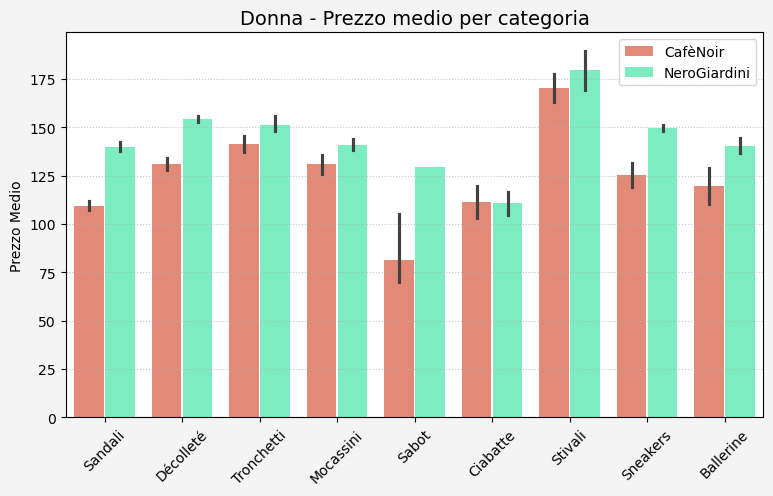

,price
category,
Mocassini,133.755319
Sneakers,140.128832
Stringate,149.836585


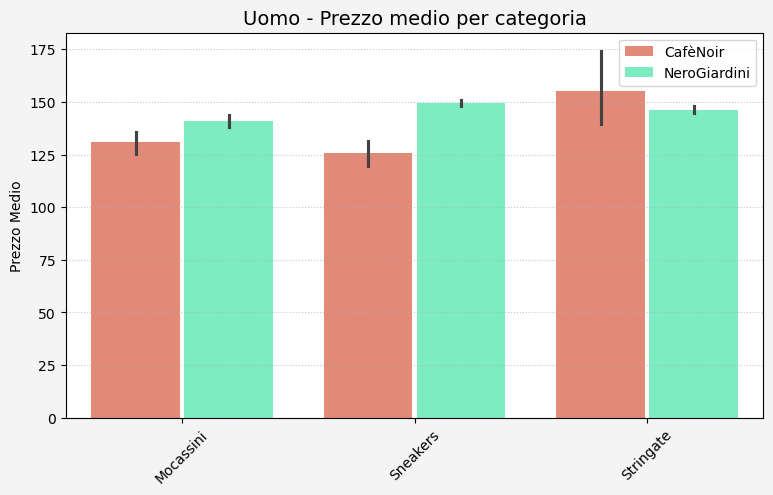

,price
category,
Ballerine,129.068182
Ciabatte,111.224324
Décolleté,144.831746
Mocassini,133.755319
Sabot,100.760000
Sandali,125.438716
Sneakers,140.128832
Stivali,170.616216
Stringate,149.836585


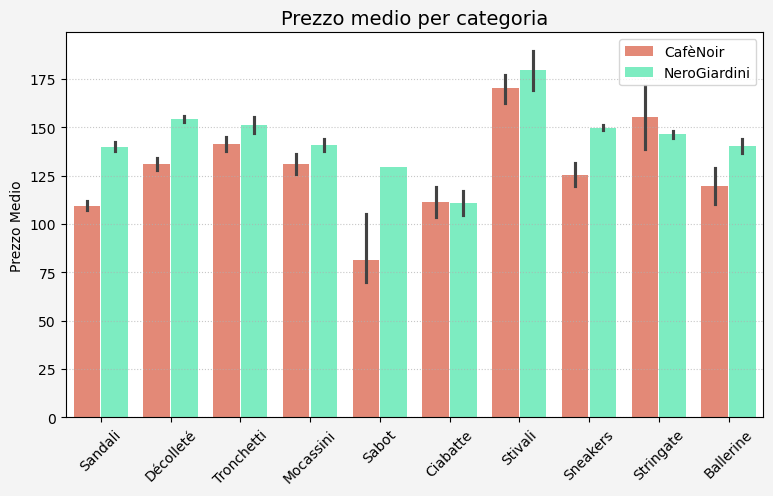

In [15]:
# creo una lista dei valori unici di 'gender'
gender_unique = list(df_comparison.gender.unique())
gender_unique.append('')

for gender in gender_unique:
    df_flt = df_comparison[df_comparison.gender == gender] if gender!='' else df_comparison
    
    common_cat = df_flt.dropna(subset='price').groupby('category')['Store'].nunique()
    cat_flt = common_cat[common_cat == 2].index
    
    df_filtrato = df_comparison[df_comparison['category'].isin(cat_flt)]
    display(df_filtrato.groupby('category').price.mean().to_frame())
    
    plt.figure(figsize=(9,5))
    ax = sns.barplot(df_filtrato, x='category', y='price', hue='Store', estimator='mean', 
                     gap=0.05, alpha=1, palette=colors)# edgecolor='black', linewidth=0.25)
    ax.set(xlabel='', ylabel='Prezzo Medio')
    
    # percentuali nel barplot
    #for cont in ax.containers:
    #    ax.bar_label(cont, fmt='%.0f€', weight='bold', size=12)
    
    #ax.get_yaxis().set_visible(False)
    
    plt.legend(title='')
    plt.title(f'{gender + ' - ' if gender!='' else ''}Prezzo medio per categoria', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="dotted", alpha=0.7) #linestyle: dotted (puntini) 
    plt.savefig('graphs/' + ax.get_title(), bbox_inches = 'tight', pad_inches=0.1)
    plt.show()

Store,CafèNoir,NeroGiardini
category,,
Ballerine,12,10
Ciabatte,27,10
Décolleté,77,142
Mocassini,100,95
Sabot,3,2
Sandali,231,252
Sneakers,108,295
Stivaletti,8,37
Stivali,35,77


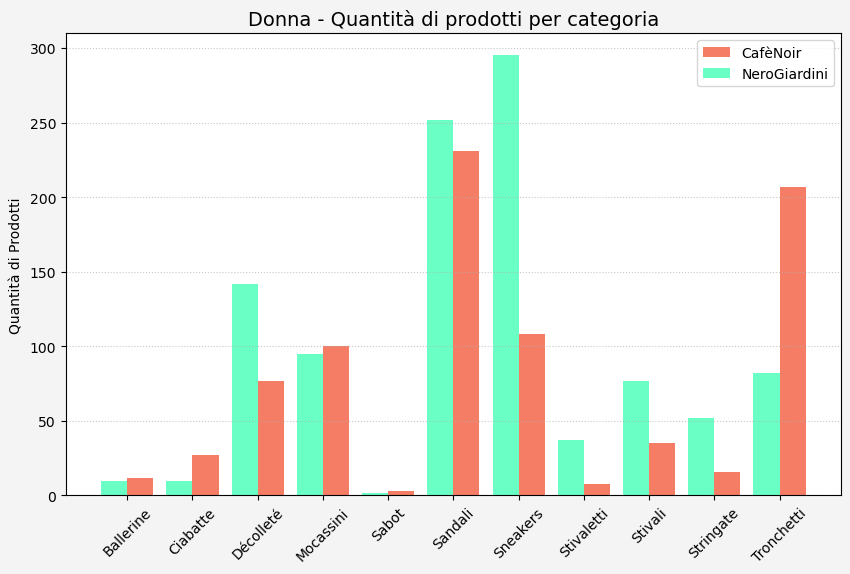

Store,CafèNoir,NeroGiardini
category,,
Mocassini,100,95
Polacchini,2,3
Sneakers,108,295
Stringate,16,52


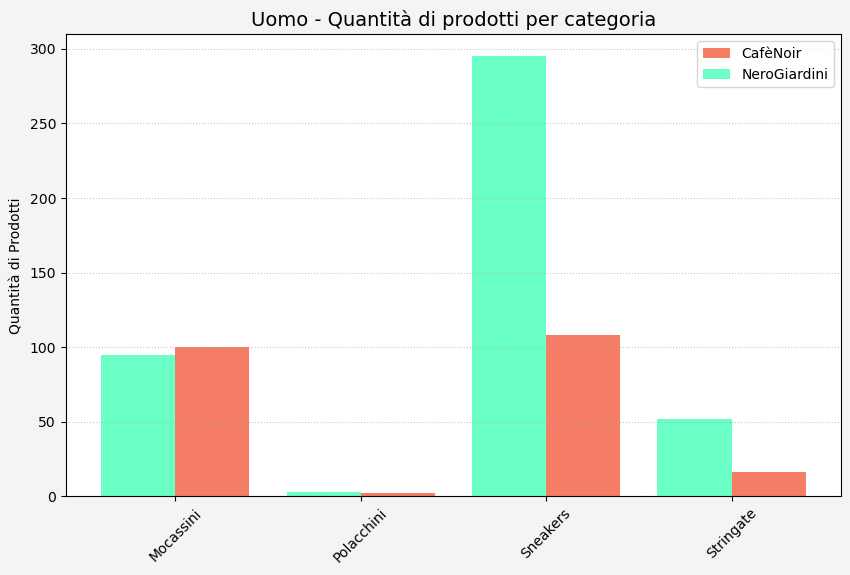

Store,CafèNoir,NeroGiardini
category,,
Ballerine,12,10
Ciabatte,27,10
Décolleté,77,142
Mocassini,100,95
Polacchini,2,3
Sabot,3,2
Sandali,231,252
Sneakers,108,295
Stivaletti,8,37


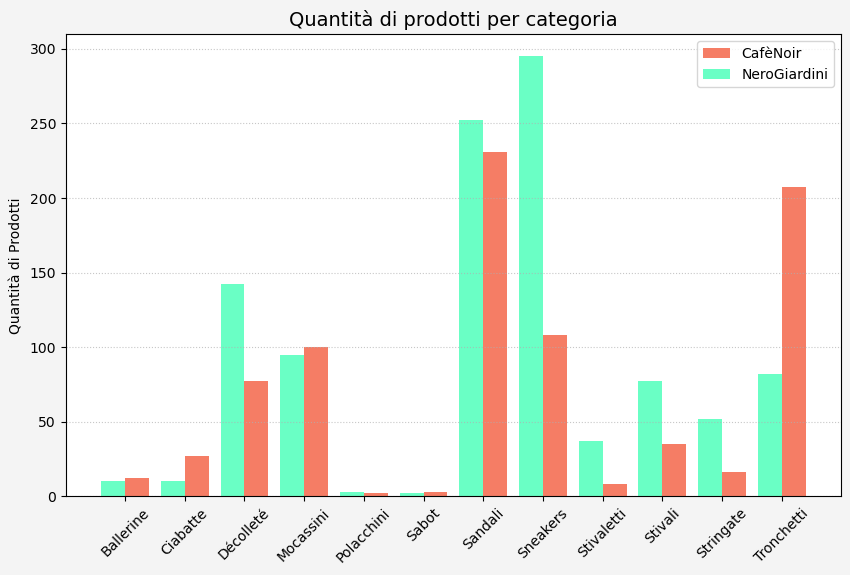

In [16]:
for gender in gender_unique:
    df_flt = df_comparison[df_comparison.gender == gender] if gender!='' else df_comparison
    
    # Conto il numero di prodotti per Store e Categoria
    conteggio_categorie = df_flt.groupby(["Store", "category"]).size().reset_index(name="Quantità")
    
    # Trovo le categorie comuni tra i due store
    categorie_comuni = conteggio_categorie.groupby("category")["Store"].nunique()
    categorie_comuni = categorie_comuni[categorie_comuni > 1].index  # Seleziona solo quelle presenti in entrambi i negozi
    
    # Filtro solo i prodotti da donna e con categorie comuni
    df_flt = df_comparison[df_comparison["category"].isin(categorie_comuni)]
    
    # Conto le quantità di prodotti per categoria e negozio
    conteggio = df_flt.groupby(["category", "Store"]).size().unstack(fill_value=0)   
    display(conteggio)
    
    # Creo grafico a barre affiancate
    plt.figure(figsize=(10, 6))
    larghezza_barra = 0.4  # Larghezza delle barre
    x = np.arange(len(conteggio))  # Posizioni sull'asse X
    
    # Barre per ogni store
    plt.bar(x + larghezza_barra/2, conteggio["CafèNoir"], width=larghezza_barra, label="CafèNoir", color=salmon_color)
    plt.bar(x - larghezza_barra/2, conteggio["NeroGiardini"], width=larghezza_barra, label="NeroGiardini", color=turq_color)
    # segno + e - dopo la x danno precedenza su quale barra visualizzare prima da sinistra a destra dello schermo 
    
    plt.xticks(x, conteggio.index, rotation=45)
    plt.xlabel("")
    plt.ylabel("Quantità di Prodotti")
    plt.title(f"{gender + ' - ' if gender!='' else ''}Quantità di prodotti per categoria", fontsize=14)
    plt.legend(title="")
    plt.grid(axis="y", linestyle="dotted", alpha=0.7) #linestyle: dotted (puntini)

    plt.savefig('graphs/' + plt.gca().get_title(), bbox_inches = 'tight', pad_inches=0.1)
    plt.show()

### Numero di prodotti in saldo per store

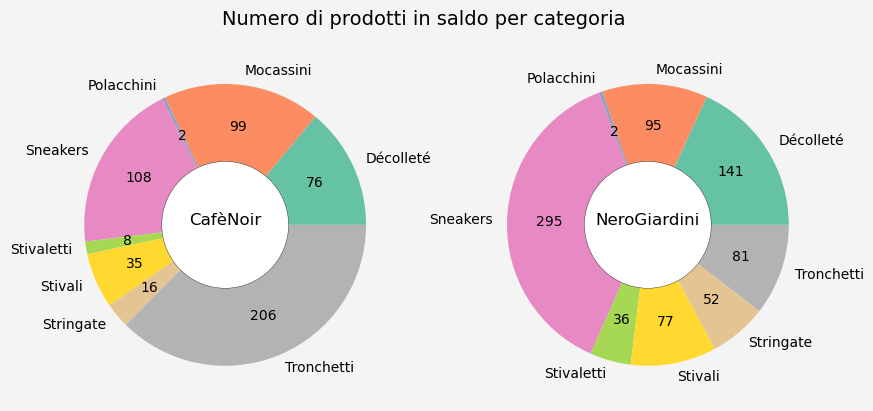

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))#, width_ratios=[3, 1.25])
fig.suptitle('Numero di prodotti in saldo per categoria', fontsize=14, y=0.925)
i = 0

for Store in df_comparison.Store.unique():
    common_cat = df_comparison.dropna(subset='sales_price').groupby('category')['Store'].nunique()
    cat_flt = common_cat[common_cat == 2].index
    
    df_filtrato = df_comparison[(df_comparison['category'].isin(cat_flt)) & (df_comparison.Store == Store)]
    df_flt_grp = df_filtrato.groupby('category')
    
    ax[i].pie(df_flt_grp.id.count(), pctdistance=0.7, colors=plt.cm.Set2.colors,
              labels=df_flt_grp.category.unique().explode().to_list(),
              autopct=lambda val: int(val/100 * df_flt_grp.id.count().sum()))
    
    circle = plt.Circle((0, 0), 0.45, fc='white', color='black', linewidth=0.25) 
    ax[i].add_patch(circle)
    ax[i].annotate(Store, xy=(0, 0), fontsize=12, ha="center")
    i+=1

plt.savefig('graphs/' + fig.get_suptitle(), bbox_inches = 'tight', pad_inches=0.1)
plt.show()

### Numero di prodotti per colori comuni

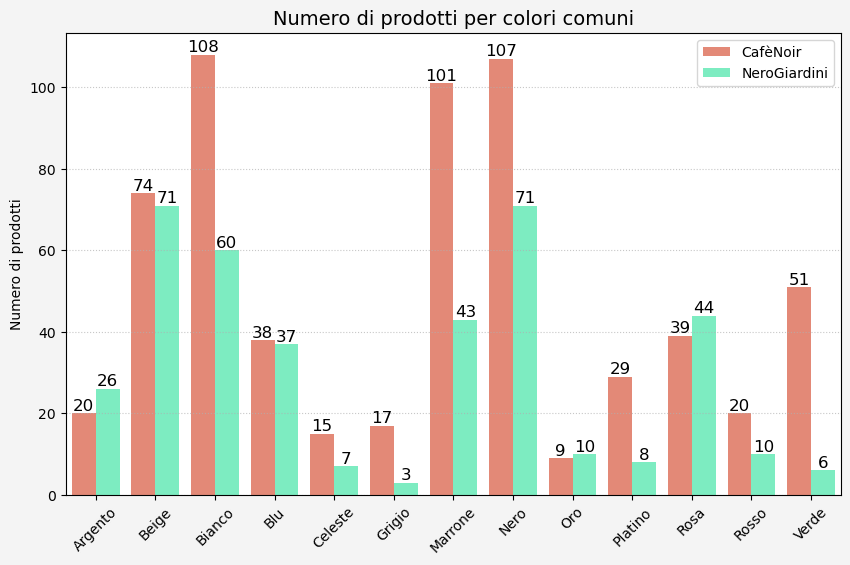

In [18]:
common_color = df_comparison.drop(columns='sales_price').dropna(subset='price').groupby('color')['Store'].nunique()
color_flt = common_color[common_color == 2].index

df_filtrato = df_comparison[(df_comparison['color'].isin(color_flt))].drop(columns='sales_price').dropna(subset='price')

plt.figure(figsize=(10, 6))
plt.title('Numero di prodotti per colori comuni', fontsize=14)
ax = sns.barplot(df_filtrato.groupby(['Store', 'color']).color.value_counts().to_frame(), estimator='sum',
            x='color', y='count', hue='Store', palette=colors)
ax.set(xlabel='', ylabel='Numero di prodotti')

# numeri sulle barplot
for cont in ax.containers:
    ax.bar_label(cont, fmt='%.0f', size=12)

plt.legend(title='')
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="dotted", alpha=0.7) #linestyle: dotted (puntini)

plt.savefig('graphs/' + plt.gca().get_title(), bbox_inches = 'tight', pad_inches=0.1)
plt.show()

### Numero di prodotti in saldo per colori comuni

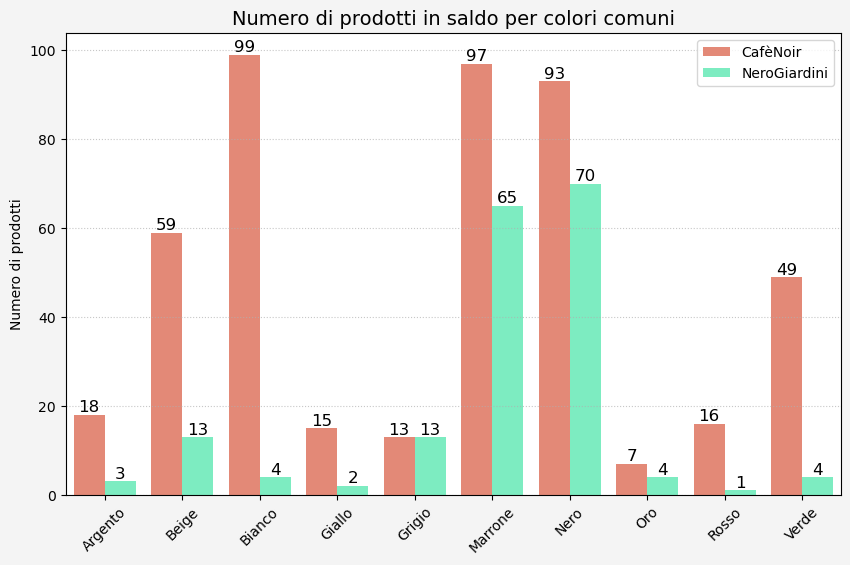

In [19]:
common_color = df_comparison.drop(columns='price').dropna(subset='sales_price').groupby('color')['Store'].nunique()
color_flt = common_color[common_color == 2].index

df_filtrato = df_comparison[(df_comparison['color'].isin(color_flt))].drop(columns='price').dropna(subset='sales_price')

plt.figure(figsize=(10, 6))
plt.title('Numero di prodotti in saldo per colori comuni', fontsize=14)
ax = sns.barplot(df_filtrato.groupby(['Store', 'color']).value_counts().to_frame(), estimator='sum',
            x='color', y='count', hue='Store', palette=colors)
ax.set(xlabel='', ylabel='Numero di prodotti')
# numeri sulle barplot
for cont in ax.containers:
    ax.bar_label(cont, fmt='%.0f', size=12)
    
plt.legend(title='')
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="dotted", alpha=0.7) #linestyle: dotted (puntini)

plt.savefig('graphs/' + plt.gca().get_title(), bbox_inches = 'tight', pad_inches=0.1)
plt.show()

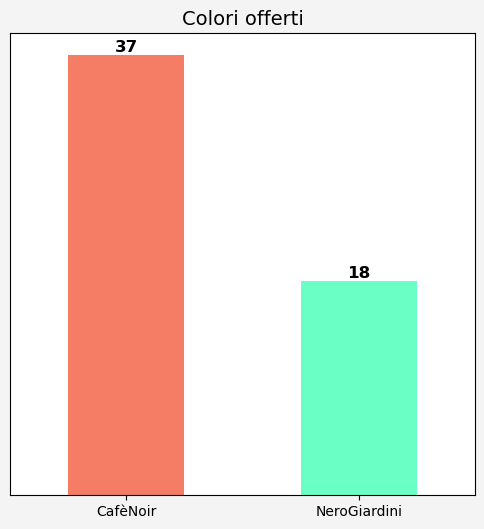

In [20]:
plt.figure(figsize=(6, 6))
plt.title('Colori offerti', fontsize=14)
ax = df_comparison.groupby('Store').color.nunique().plot.bar(color=colors, ylabel='Numero di colori', xlabel='')

# numeri sulle barplot
for cont in ax.containers:
    ax.bar_label(cont, fmt='%.0f', weight='bold', size=12)

ax.get_yaxis().set_visible(False)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="dotted", alpha=0.7) #linestyle: dotted (puntini)
plt.savefig('graphs/' + plt.gca().get_title(), bbox_inches = 'tight', pad_inches=0.1)
plt.show()

### Prezzo medio per store

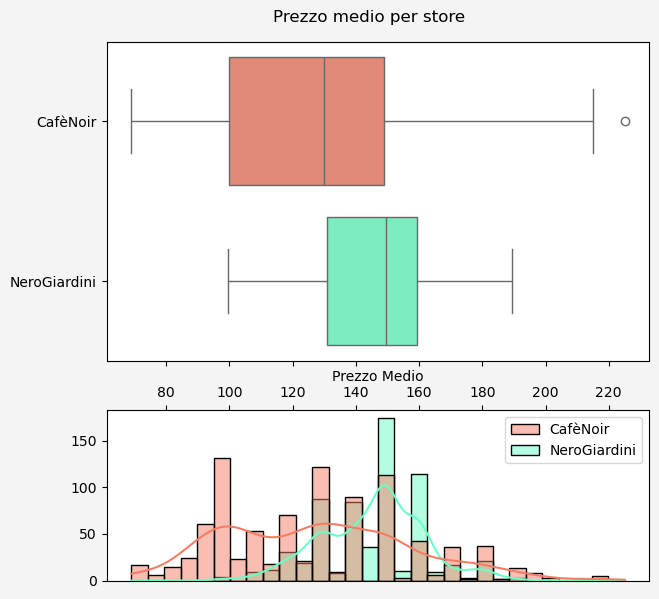

In [21]:
common_cat = df_comparison.dropna(subset='price').groupby('category')['Store'].nunique()
cat_flt = common_cat[common_cat == 2].index

df_filtrato = df_comparison.dropna(subset='price')#[df_comparison['category'].isin(cat_flt)]

# boxplot
fig, ax = plt.subplots(2, figsize=(7,7), height_ratios=[3, 1.6], sharex=True)
plt.subplots_adjust(wspace = 0.05)
fig.suptitle('Prezzo medio per store', fontsize=12, y=0.925)

sns.boxplot(df_filtrato, y='Store', x='price', hue='Store', palette=colors, ax=ax[0]).set(xlabel='Prezzo Medio', ylabel='')

# istogramma
sns.histplot(df_filtrato, x='price', hue='Store', bins=30, ax=ax[1], palette=colors, kde=True).set(xlabel='Prezzo Medio', ylabel='')
ax[1].get_legend().set_title('')
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position("top")
ax[1].yaxis.tick_left() 
ax[1].yaxis.set_label_position("right")
plt.savefig('graphs/' + plt.gca().get_title(), bbox_inches = 'tight', pad_inches=0.1)
plt.show()

In [22]:
price_max = df_comparison[df_comparison.Store == 'CafèNoir'].price.max()
print(price_max)
df_comparison[(df_comparison.Store == 'CafèNoir') & (df_comparison.price == price_max)].name.to_list()

225.0


['stivale donna in pelle cognac']

In [23]:
price_min = df_comparison[df_comparison.Store == 'CafèNoir'].price.min()
print(price_min)
df_comparison[(df_comparison.Store == 'CafèNoir') & (df_comparison.price == price_min)].name.to_list()

69.0


['sandali bassi modello ciabatta in sughero e strass bicolor arancio/marrone',
 'infradito modello ciabatta in sughero e strass degradè multi marrone',
 'sandali bassi modello ciabatta in sughero e strass degradè multi marrone']